- WAL이 해결하는 문제를 명확히 하기 위해 첫 번째 하위 섹션에서는 PostgreSQL이 WAL을 구현하지 않는 경우 충돌이 발생할 때 어떤 일이 발생하는지 보여줌.
- 두 번째 하위 섹션에서는 몇 가지 핵심 개념을 소개하고 이 장의 주요 주제인 WAL 데이터 작성 및 데이터베이스 복구 프로세스에 대한 개요를 보여줌.
- 마지막 하위 섹션에서는 핵심 개념을 하나 더 추가하여 WAL 개요를 완성.

<BR>

- 본 절에서는 설명을 단순화하기 위해 한 페이지만 포함하는 TABLE_A 테이블을 사용

# **Insertion Operations without WAL**

- 모든 DBMS는 관계 페이지에 대한 효율적인 액세스를 제공하기 위해 공유 버퍼 풀을 구현

- WAL 기능을 구현하지 않는 PostgreSQL의 TABLE_A에 일부 데이터 튜플을 삽입한다고 가정

 **Insertion operations without WAL.**

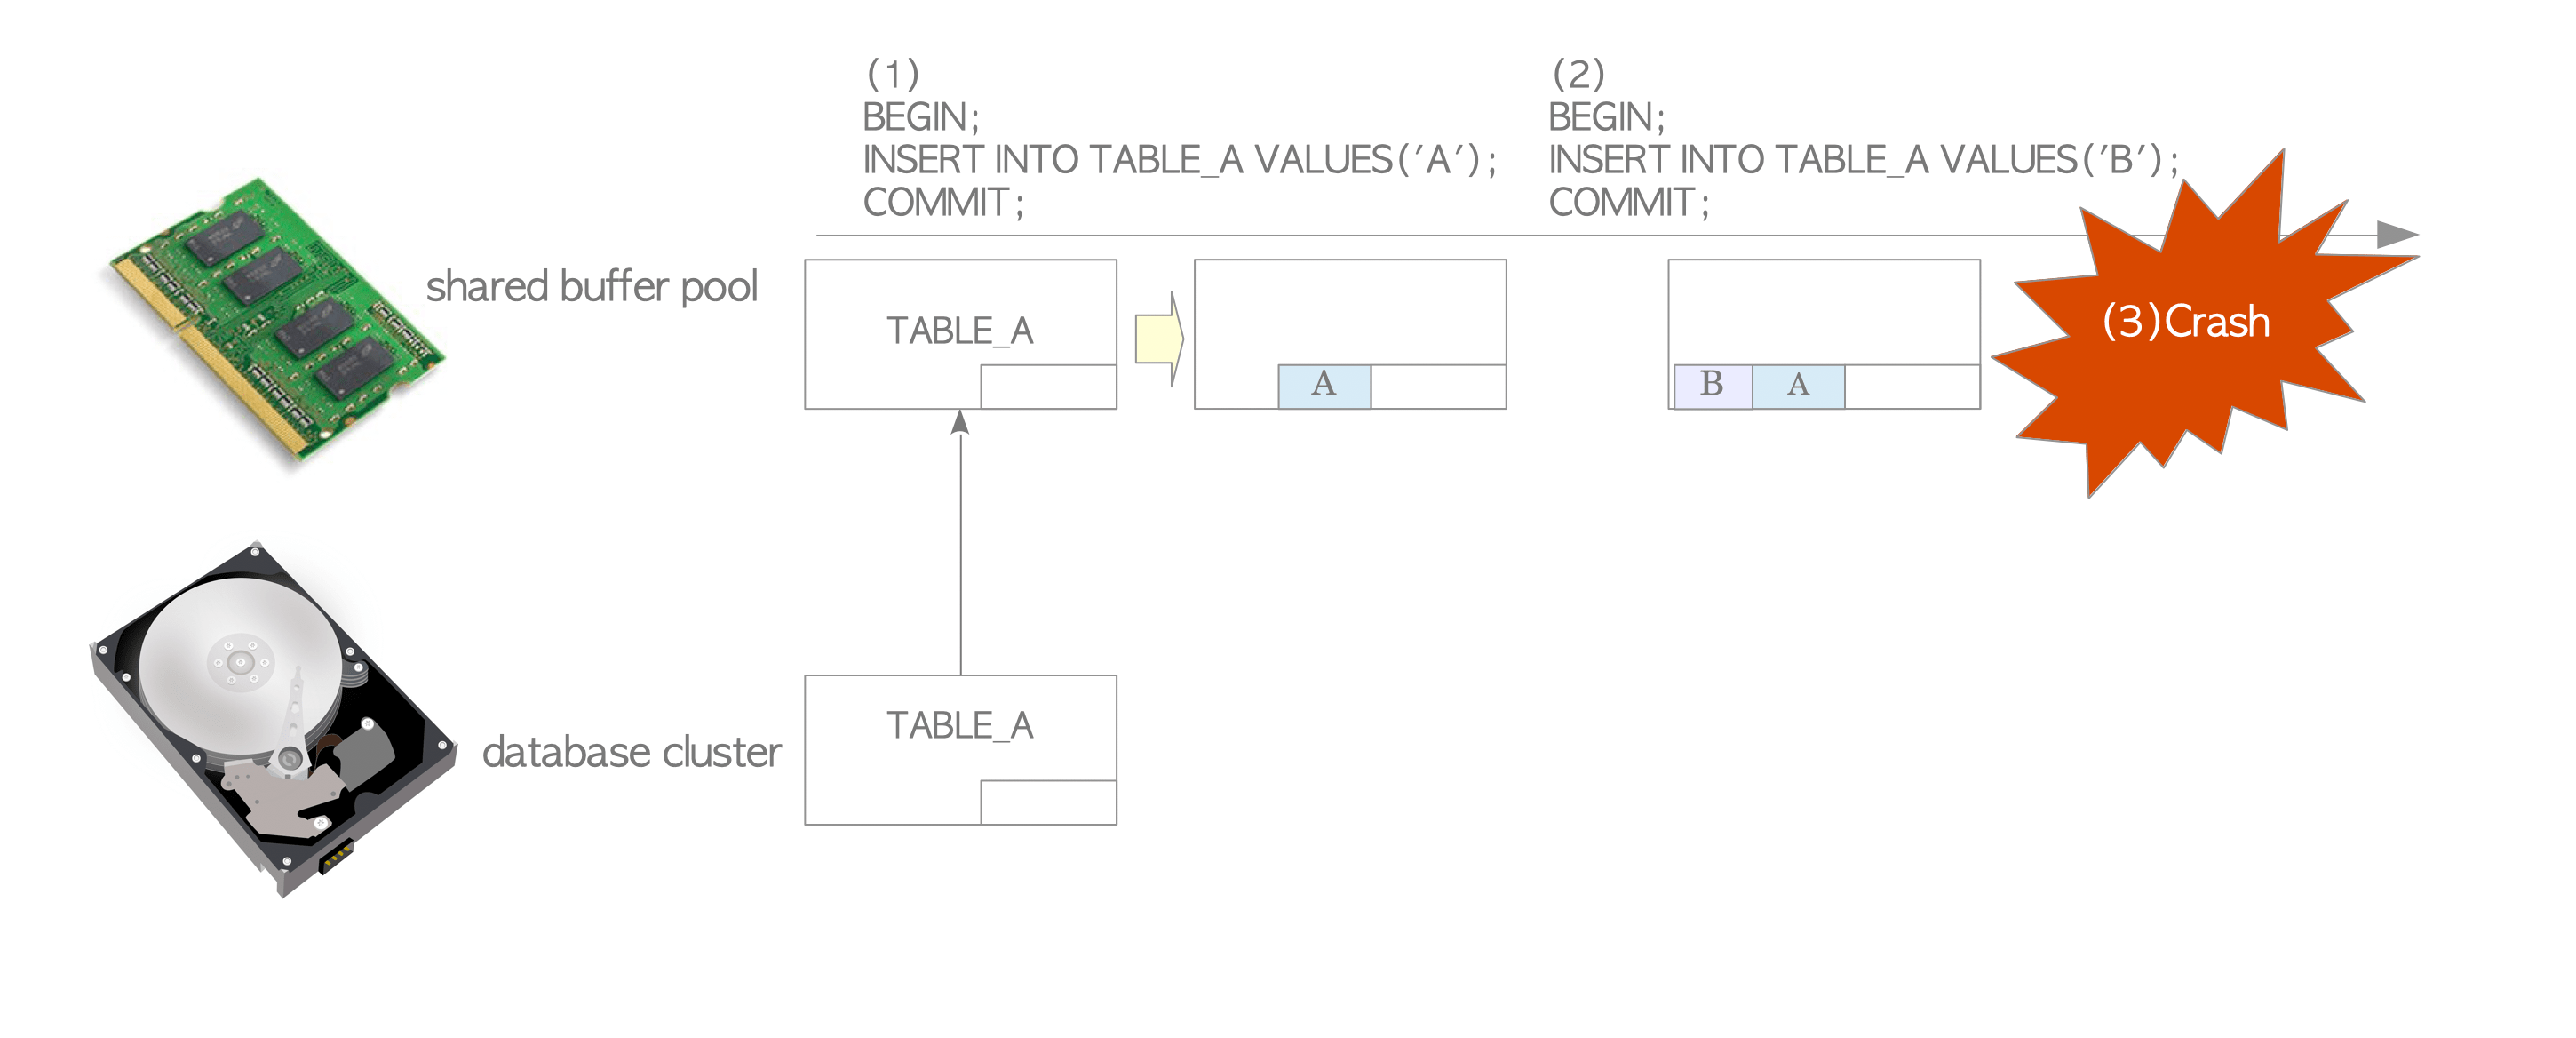

1. 첫 번째 INSERT 문을 실행하면 PostgreSQL은 데이터베이스 클러스터의 TABLE_A 페이지를 메모리 내 공유 버퍼 풀로 로드하고 페이지에 튜플을 삽입
 - 페이지는 데이터베이스 클러스터에 즉시 기록되지 않음. (수정된 페이지를 일반적으로 더티 페이지 라고 함)

2. 두 번째 INSERT 문을 실행하면 PostgreSQL은 버퍼 풀의 페이지에 새 튜플을 삽입.
  - 페이지가 아직 저장소에 기록되지 않았습니다.

3. 운영 체제 또는 PostgreSQL 서버가 정전 등 어떤 이유로든 장애가 발생하면 삽입된 모든 데이터가 손실됨.

- 따라서 WAL이 없는 데이터베이스는 시스템 오류에 취약.

<BR>

**Historical Info**

- WAL이 도입되기 전에(버전 7.0 이하) PostgreSQL은 내구성을 보장하기 위해 페이지가 메모리에서 변경될 때마다 동기화 시스템 호출을 실행하여 디스크에 동기식 쓰기를 수행.
  - 이로 인해 INSERT 및 UPDATE와 같은 수정 명령의 성능이 매우 저하되었음

# **Insertion Operations and Database Recovery**

- 성능 저하 없이 위에서 언급한 시스템 오류를 처리하기 위해 PostgreSQL은 WAL을 지원.

- 이 하위 섹션에서는 몇 가지 키워드와 핵심 개념을 설명한 다음 WAL 데이터 작성 및 데이터베이스 복구를 설명.

- PostgreSQL은 오류에 대비하기 위해 모든 수정 사항을 기록 데이터로 영구 저장소에 기록.
- PostgreSQL에서 기록 데이터는 XLOG 레코드 또는 WAL 데이터 로 알려져 있음.

- XLOG 레코드는 삽입, 삭제 또는 커밋 작업과 같은 변경 작업을 통해 메모리 내 WAL 버퍼 에 기록됨.
  - 트랜잭션이 커밋되거나 중단되면 저장소의 WAL 세그먼트 파일 에 즉시 기록됨 . (정확하게는 XLOG 레코드 쓰기가 다른 경우에도 발생할 수 있음)
  - XLOG 레코드의 LSN(Log Sequence Number)은 해당 레코드가 트랜잭션 로그에 기록되는 위치를 나타냄.
  - 레코드의 LSN은 XLOG 레코드의 고유 ID로 사용됨.

- 데이터베이스 시스템 복구 방법을 고려할 때 발생할 수 있는 한 가지 질문은 PostgreSQL이 어느 시점부터 복구를 시작합니까?임.
  - 답은 REDO 포인트
  - 가장 최근 체크포인트가 시작되는 순간 XLOG 레코드를 쓰는 위치
  - 실제로 데이터베이스 복구 프로세스는 체크포인트 프로세스 와 밀접하게 연결되어 있으며 이 두 프로세스는 분리될 수 없음.

**Info**

- WAL과 체크포인트 프로세스는 버전 7.1에서 동시에 구현되었음.

- 주요 키워드 및 개념 소개가 끝났으므로 다음은 WAL을 이용한 튜플 삽입에 대한 설명


 **Insertion operations with WAL.**

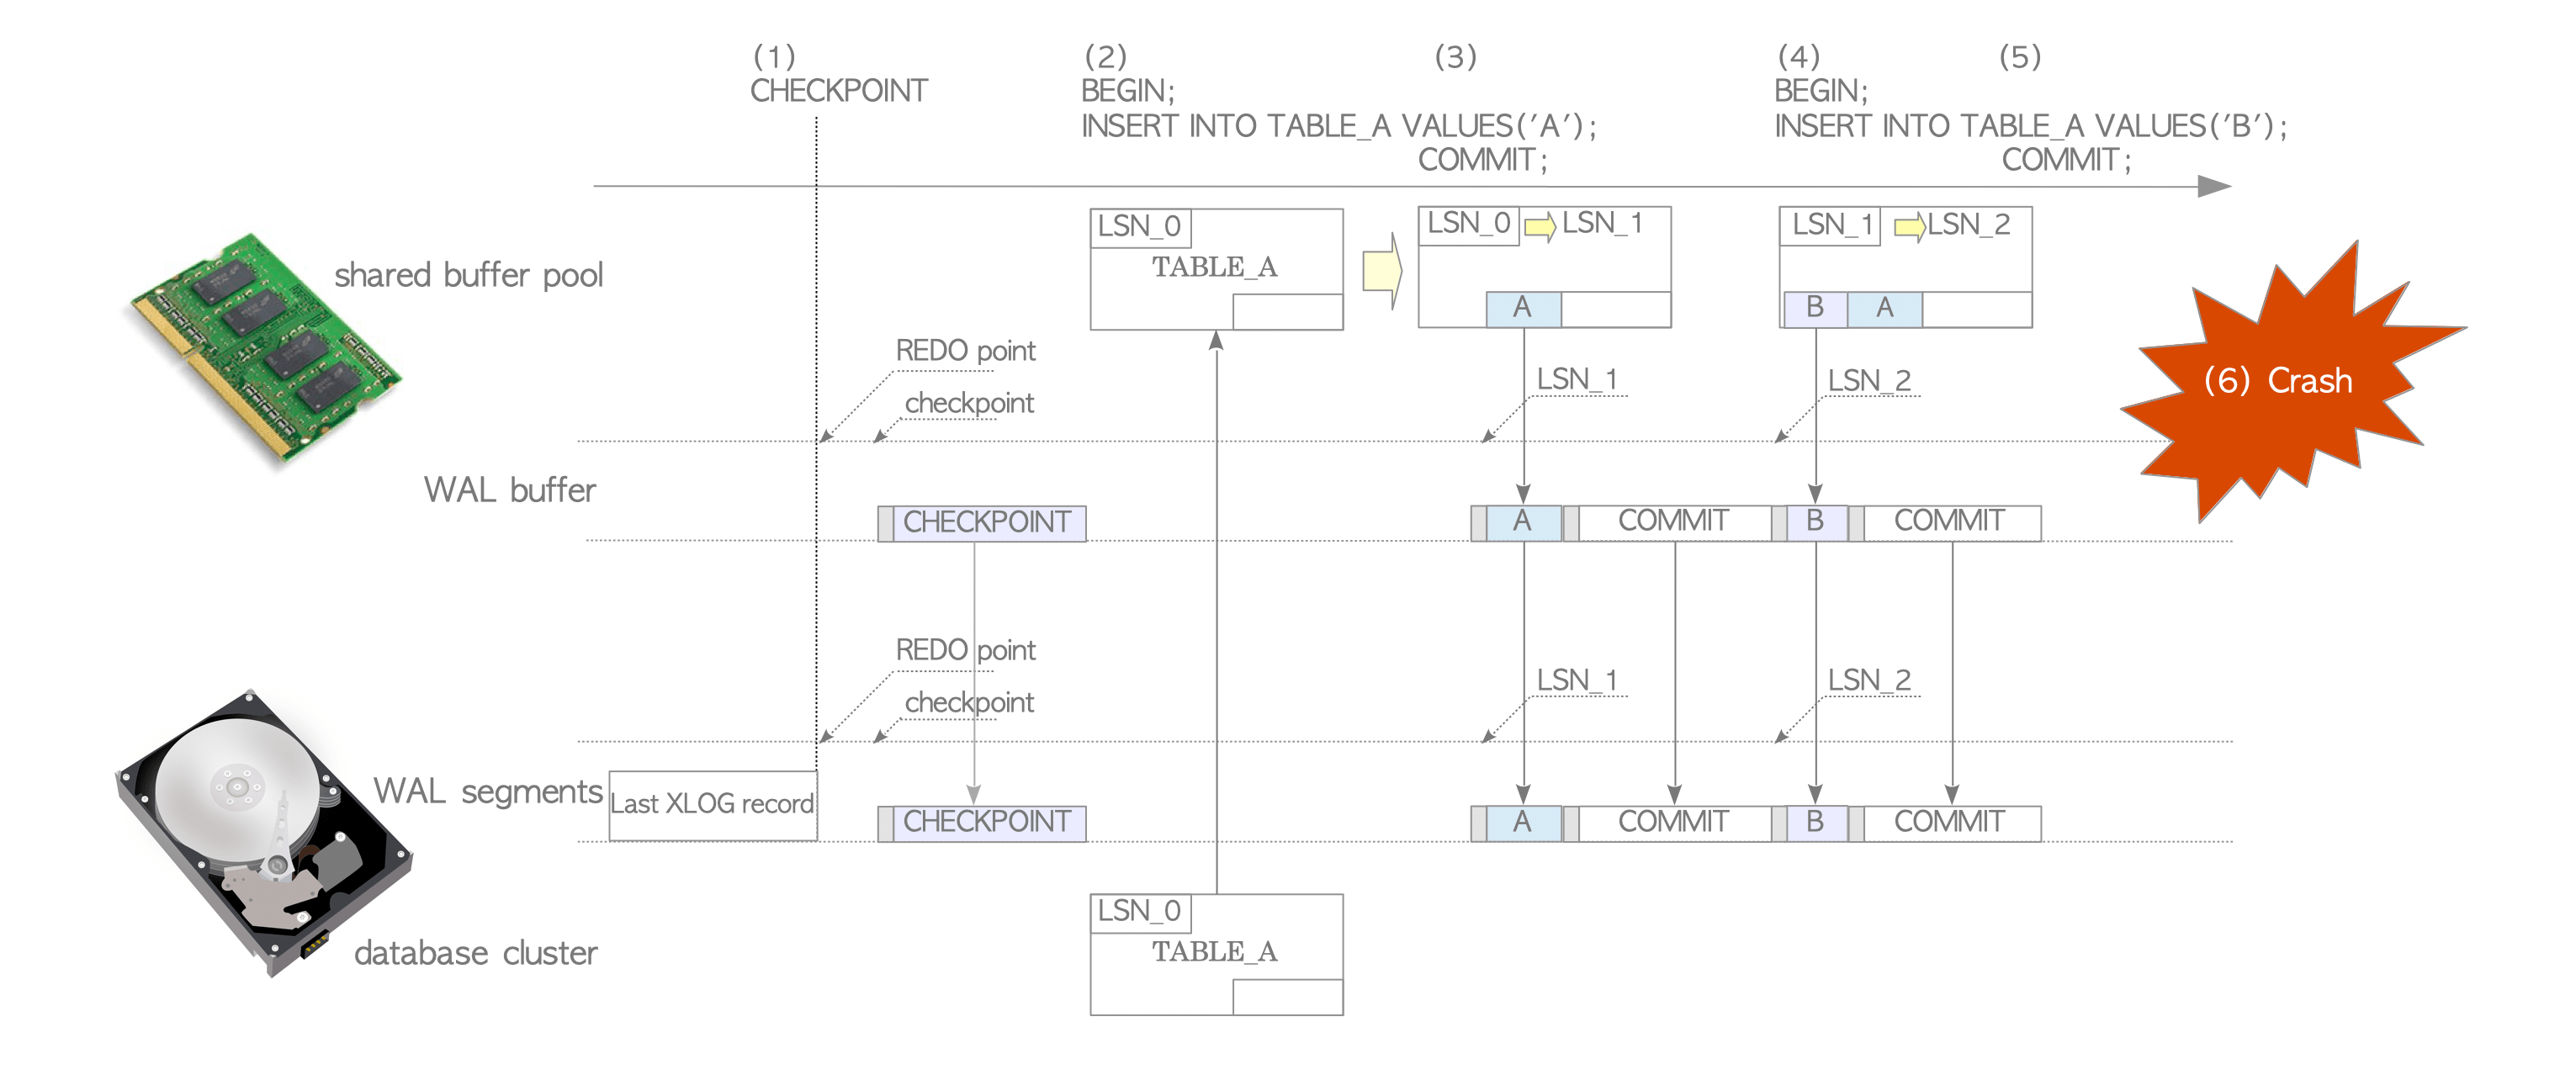

**Notation**

- TABLE_A의 LSN은 TABLE_A의 페이지 헤더 내 'pd_lsn' 값을 표시.
- 페이지의 LSN 도 같은 방식.

1. 백그라운드 프로세스인 체크포인터(checkpointer)는 주기적으로 체크포인트를 수행.
  - 체크포인터가 시작될 때마다 체크포인트 레코드 라는 XLOG 레코드를 현재 WAL 세그먼트에 씀
  - 이 레코드에는 최신 REDO 지점 의 위치가 포함되어 있음.

2. 첫 번째 INSERT 문을 실행하면 PostgreSQL은 TABLE_A 페이지를 공유 버퍼 풀에 로드하고, 페이지에 튜플을 삽입하고, 이 문의 XLOG 레코드를 생성하여 LSN_1 위치의 WAL 버퍼에 쓰고, TABLE_A의 LSN은 LSN_0부터 LSN_1까지임.
  - 이 예에서 이 XLOG 레코드는 헤더 데이터와 튜플 전체의 쌍

3. 이 트랜잭션이 커밋되면 PostgreSQL은 이 커밋 작업의 XLOG 레코드를 생성하여 WAL 버퍼에 쓴 다음 WAL 버퍼의 모든 XLOG 레코드를 LSN_1에서 WAL 세그먼트 파일에 쓰고 플러시

4. 두 번째 INSERT 문을 실행하면 PostgreSQL은 페이지에 새 튜플을 삽입하고 이 튜플의 XLOG 레코드를 생성하여 LSN_2의 WAL 버퍼에 쓴 다음 TABLE_A의 LSN을 LSN_1에서 LSN_2로 업데이트.

5. 이 문의 트랜잭션이 커밋되면 PostgreSQL은 3단계와 동일한 방식으로 동작.

6. 운영 체제 오류가 발생했다고 가정.
  - 공유 버퍼 풀의 모든 데이터가 손실되더라도 페이지에 대한 모든 수정 사항은 WAL 세그먼트 파일에 기록 데이터로 기록됨.

- 다음 지침은 데이터베이스 클러스터를 충돌 직전 상태로 다시 복구하는 방법을 보여줌.
  - PostgreSQL은 다시 시작하면 자동으로 복구 모드로 전환되므로 특별한 작업을 수행할 필요가 없음.
  - PostgreSQL은 REDO 지점의 적절한 WAL 세그먼트 파일 내에서 XLOG 레코드를 순차적으로 읽고 재생

**Database recovery using WAL.**


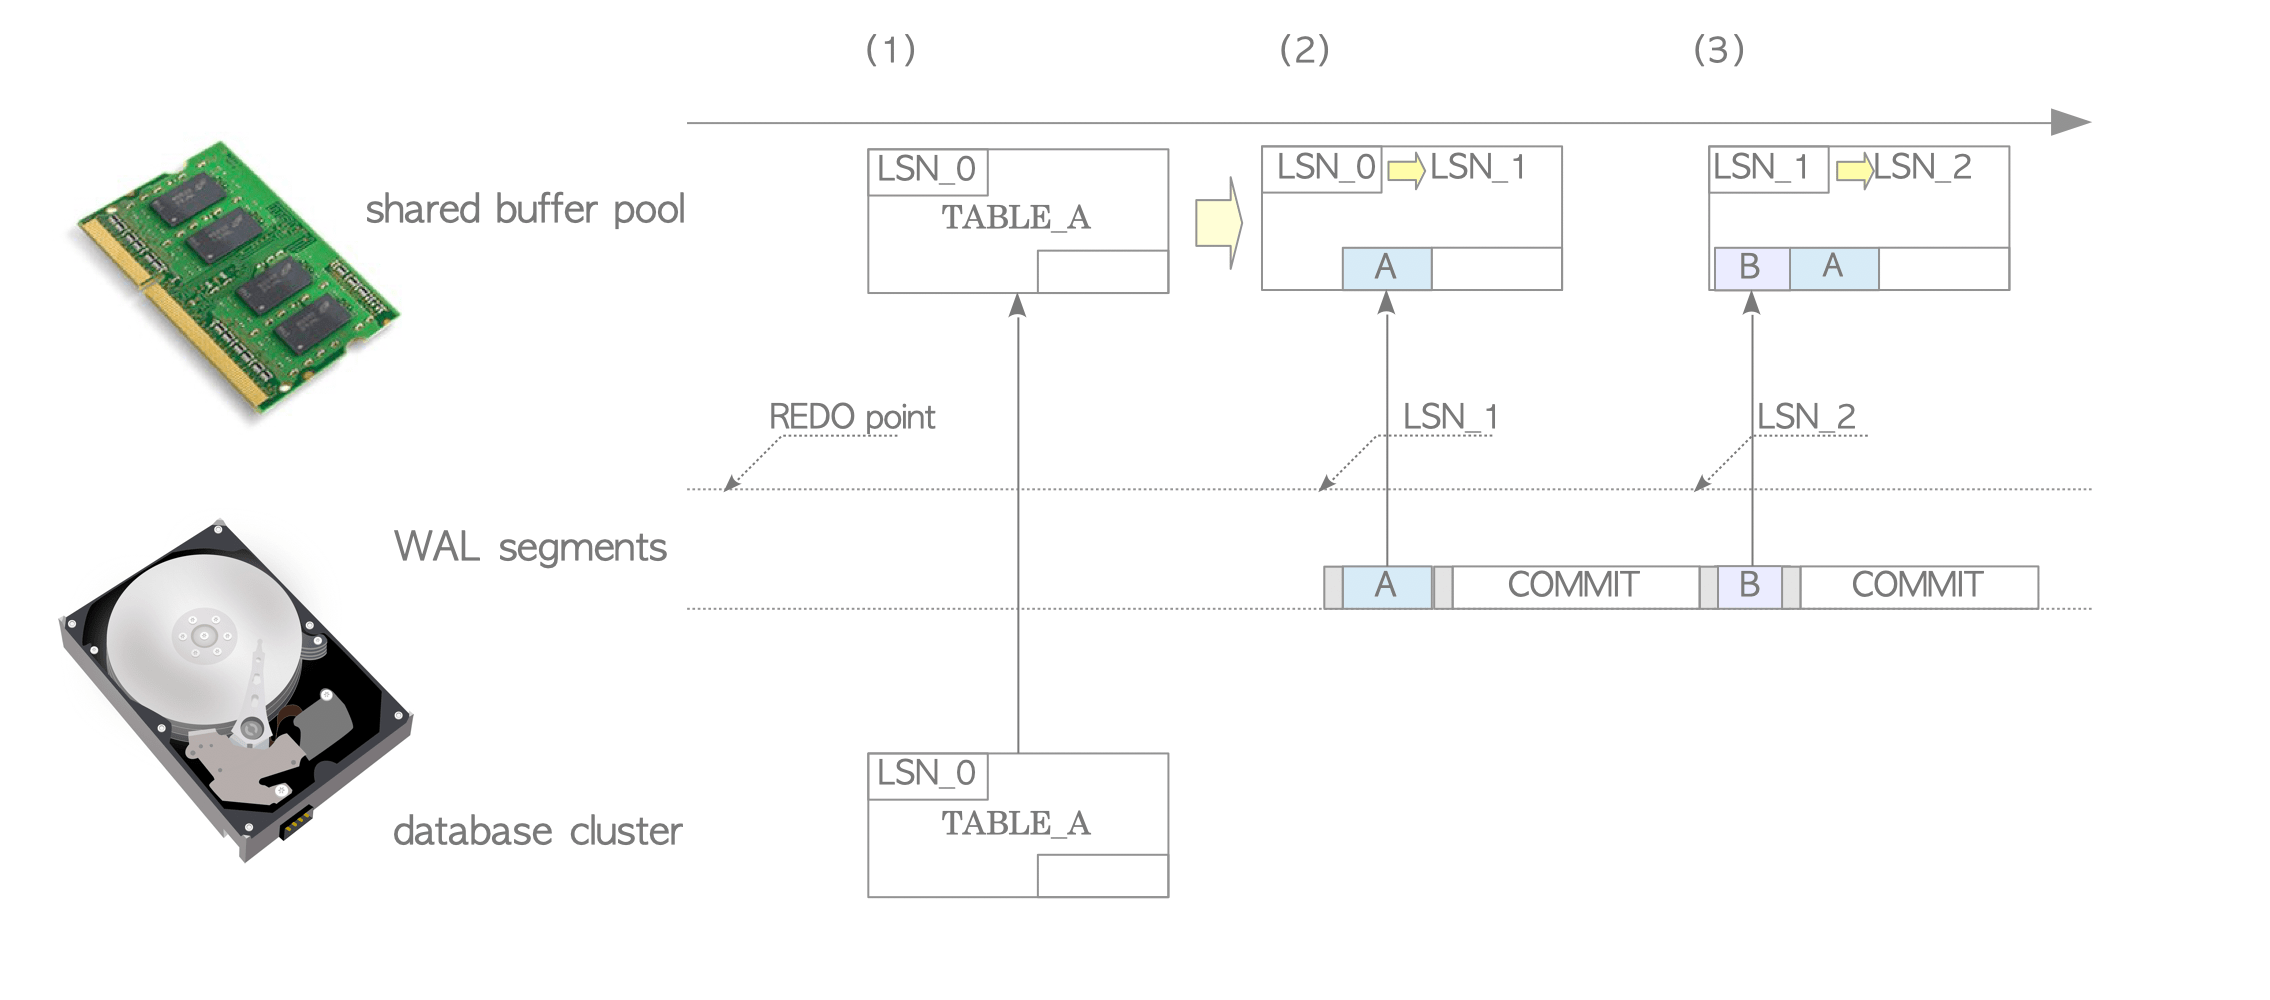

1. PostgreSQL은 해당 WAL 세그먼트 파일에서 첫 번째 INSERT 문의 XLOG 레코드를 읽고 데이터베이스 클러스터의 TABLE_A 페이지를 공유 버퍼 풀로 로드.

2. XLOG 레코드 재생을 시도하기 전에 PostgreSQL은 XLOG 레코드의 LSN과 해당 페이지의 LSN을 비교.
- XLOG 레코드 재생 규칙은 다음과 같음.
  - XLOG 레코드의 LSN이 페이지의 LSN보다 크면 XLOG 레코드의 데이터 부분이 페이지에 삽입되고 페이지의 LSN이 XLOG 레코드의 LSN으로 업데이트됨.
  - 반면 XLOG 레코드의 LSN이 더 작다면 다음 WAL 레코드를 읽는 것 외에는 할 수 있는 일이 없음.
  - 이 예에서는 XLOG 레코드의 LSN(LSN_1)이 TABLE_A의 LSN(LSN_0)보다 크기 때문에 XLOG 레코드가 재생됨.
  - 그런 다음 TABLE_A의 LSN이 LSN_0에서 LSN_1로 업데이트됨.

3. PostgreSQL은 나머지 XLOG 레코드를 동일한 방식으로 재생.

- PostgreSQL은 WAL 세그먼트 파일에 작성된 XLOG 레코드를 시간순으로 재생하여 이러한 방식으로 자체 복구할 수 있음.
- 따라서 PostgreSQL의 XLOG 레코드는 REDO 로그

**Note**
- **PostgreSQL은 UNDO 로그를 지원하지 않음.**

<br>

- XLOG 레코드를 작성하는 데는 확실히 일정 비용이 들지만 전체 수정 페이지를 작성하는 것에 비하면 아무것도 아님.
- 즉 시스템 장애 허용치가 우리가 지불하는 금액보다 크다고 확신함.

# **Full-Page Writes**

- 백그라운드 기록기 프로세스가 더티 페이지를 쓰는 동안 운영 체제에 오류가 발생하여 저장소에 있는 TABLE_A의 페이지 데이터가 손상되었다고 가정
  - 손상된 페이지에서는 XLOG 레코드를 재생할 수 없으므로 추가 기능이 필요.

<br>

- PostgreSQL은 이러한 오류를 처리하기 위해 전체 페이지 쓰기 라는 기능을 지원
  - 활성화된 경우 PostgreSQL은 모든 체크포인트 이후 각 페이지의 첫 번째 변경 중에 헤더 데이터 쌍과 전체 페이지를 XLOG 레코드로 기록.(이것이 기본 설정.)
  - PostgreSQL에서는 전체 페이지를 포함하는 이러한 XLOG 레코드를 백업 블록 (또는 전체 페이지 이미지 )이라고 g함.

- 전체 페이지 쓰기가 활성화된 상태에서 튜플 삽입을 다시 설명

**Full page writes.**

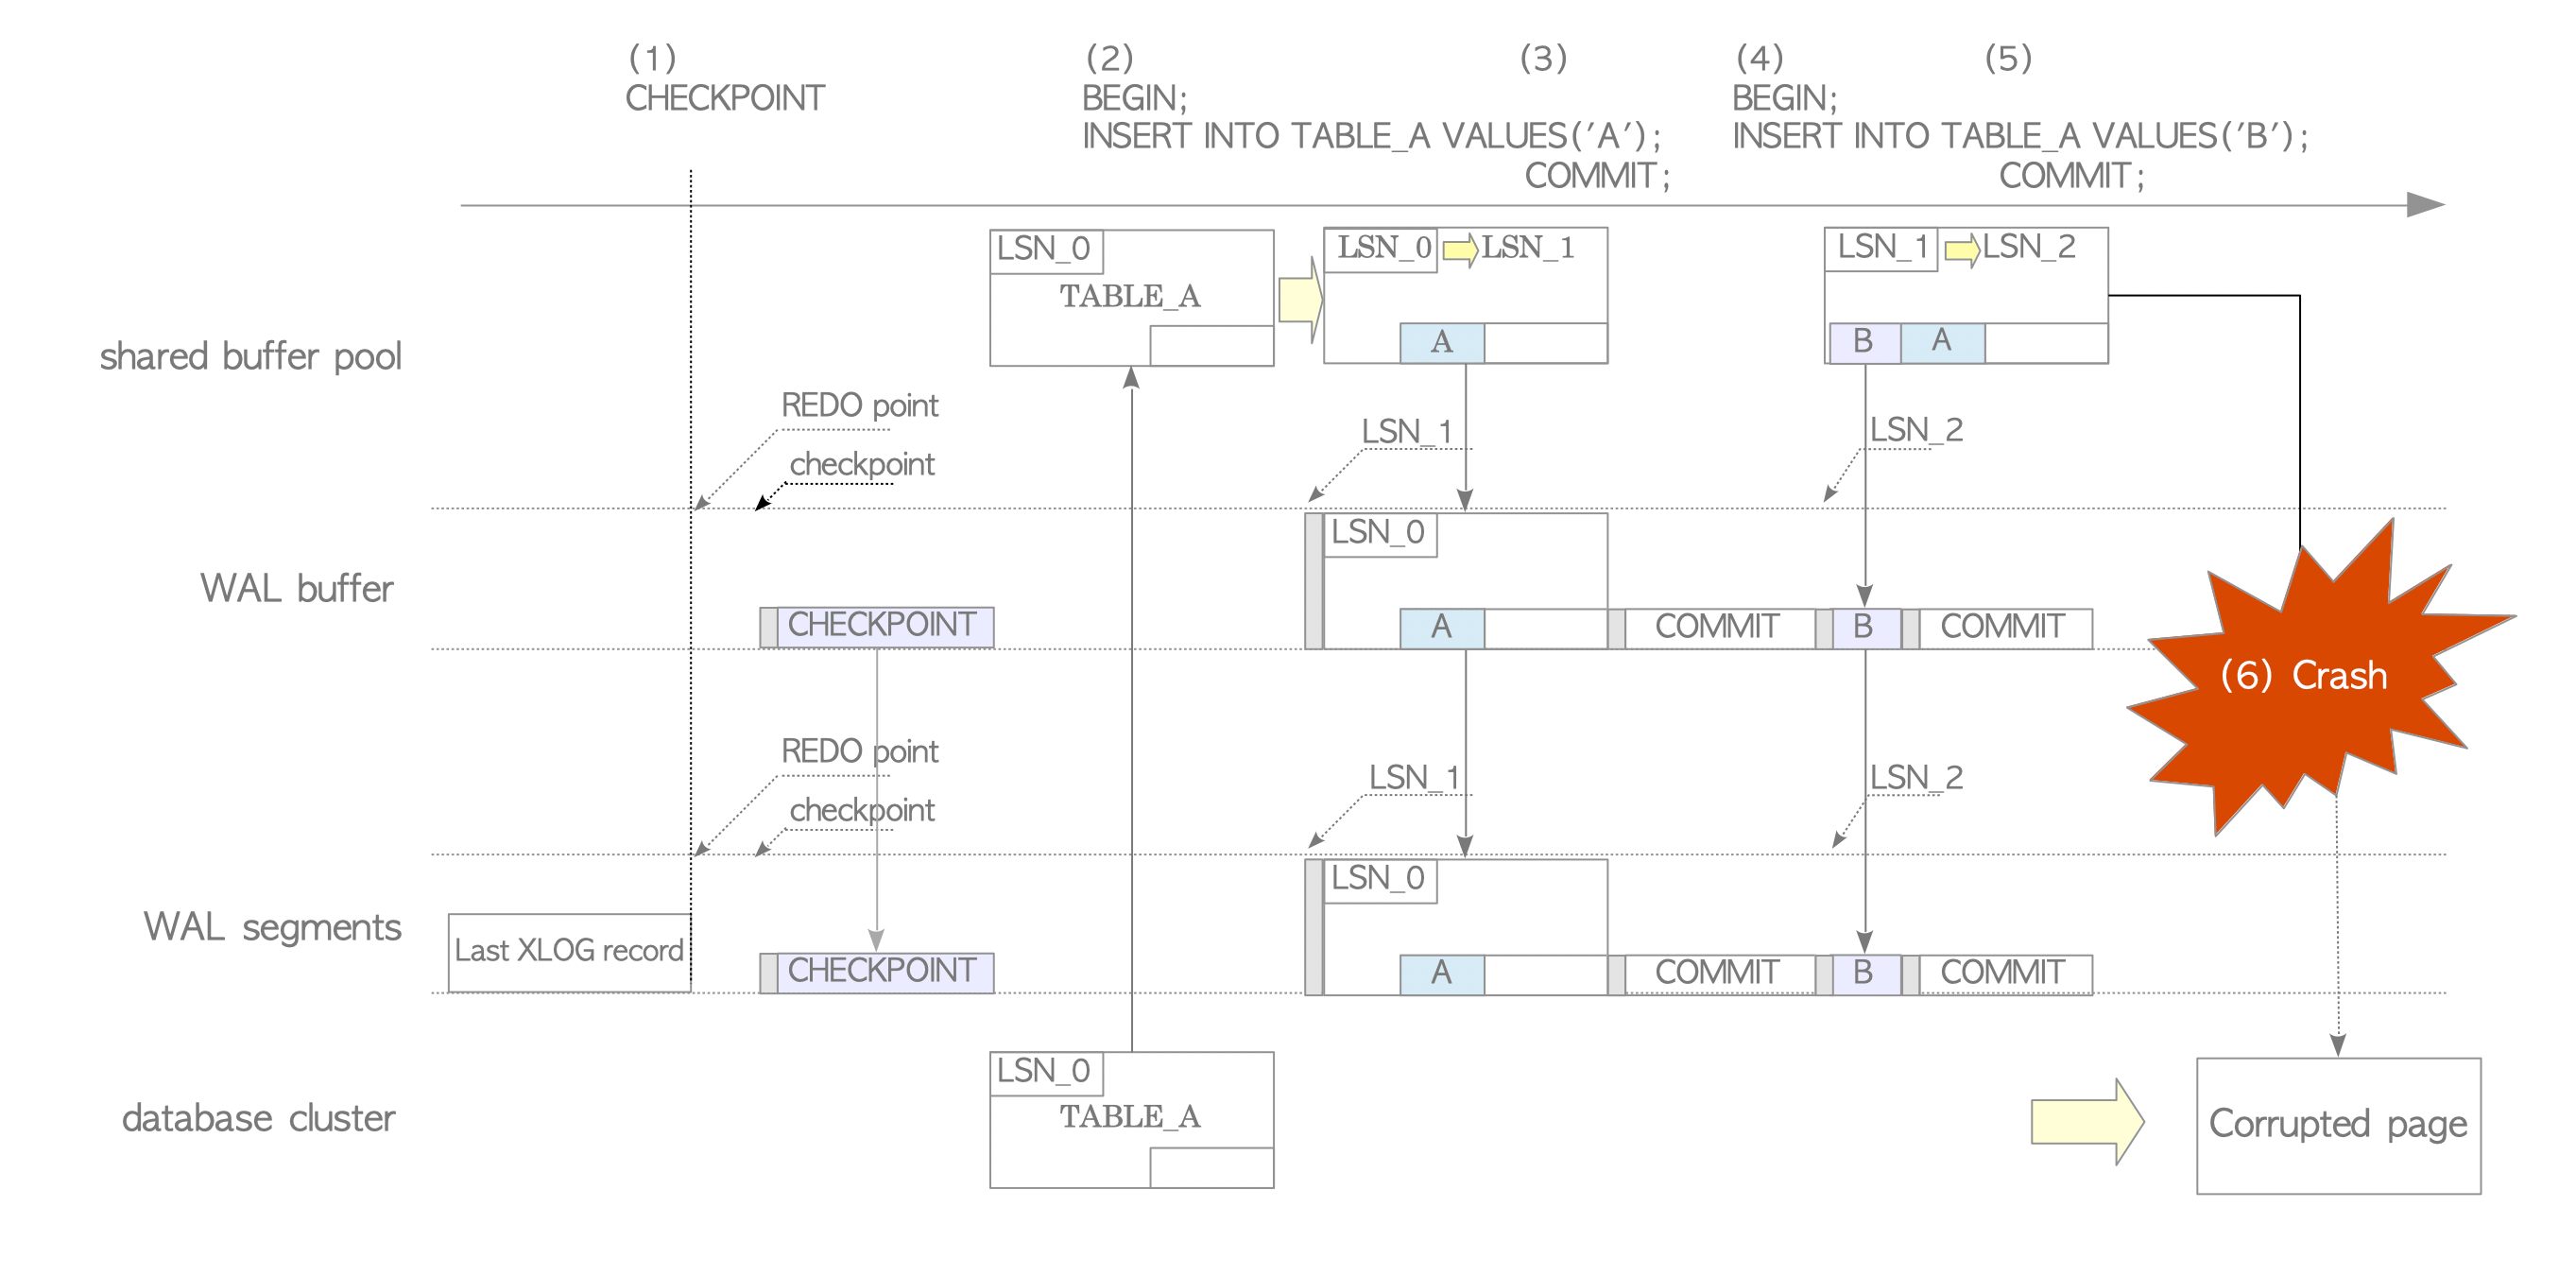

1. 체크포인터는 체크포인트 프로세스를 시작.

2. 첫 번째 INSERT 문을 삽입하면 PostgreSQL은 이전 하위 섹션과 동일한 방식으로 작동하지만 이 XLOG 레코드는 이 페이지의 백업 블록
  - 왜냐하면 이것이 최신 체크포인트 이후 이 페이지에 대한 첫 번째 쓰기이기 때문. (즉, 전체 페이지를 포함.)

3. 이 트랜잭션이 커밋되면 PostgreSQL은 이전 하위 섹션과 동일한 방식으로 작동.

4. 두 번째 INSERT 문을 삽입하면 이 XLOG 레코드가 백업 블록이 아니기 때문에 PostgreSQL은 이전 하위 섹션과 동일한 방식으로 작동.

5. 이 문의 트랜잭션이 커밋되면 PostgreSQL은 이전 하위 섹션과 동일한 방식으로 작동.

6. 전체 페이지 쓰기의 효율성을 입증하기 위해 백그라운드 기록기가 스토리지(HDD 또는 SSD)에 쓰는 동안 발생한 운영 체제 오류로 인해 스토리지의 TABLE_A 페이지가 손상된 경우를 가정

- 손상된 클러스터를 복구하려면 PostgreSQL 서버를 다시 시작

 **Database recovery with backup block.**

1. PostgreSQL은 첫 번째 INSERT 문의 XLOG 레코드를 읽고 손상된 TABLE_A 페이지를 데이터베이스 클러스터에서 공유 버퍼 풀로 로드.
  - 이 예에서 XLOG 레코드는 백업 블록.
  - 왜냐하면 각 페이지의 첫 번째 XLOG 레코드는 전체 페이지 쓰기의 쓰기 규칙에 따라 항상 백업 블록이기 때문.

2. XLOG 레코드가 백업 블록인 경우 재생의 또 다른 규칙이 적용됨.
  - 즉, 두 LSN 및 페이지의 LSN 값에 관계없이 레코드의 데이터 부분(즉, 페이지 자체)을 페이지에 덮어씀.
  - XLOG 레코드의 LSN으로 업데이트 되었음.
  - 이 예에서 PostgreSQL은 손상된 페이지에 대한 레코드의 데이터 부분을 덮어쓰고 TABLE_A의 LSN을 LSN_1로 업데이트.
  - 이러한 방식으로 손상된 페이지는 백업 블록에 의해 복원됨.

3. 두 번째 XLOG 레코드는 비백업 블록이므로 PostgreSQL은 앞 절의 명령어와 동일하게 동작.

- 이런 방식으로 PostgreSQL은 프로세스나 운영 체제 충돌로 인해 일부 데이터 쓰기 오류가 발생하더라도 데이터베이스를 복구할 수 있음

<br>

**WAL, Backup, and Replication**

- 위에서 언급한 것처럼 WAL은 프로세스 또는 운영 체제 충돌로 인한 데이터 손실을 방지할 수 있음.
  - 그러나 파일 시스템이나 미디어 오류가 발생하면 데이터가 손실됨. 이러한 오류를 처리하기 위해 PostgreSQL은 온라인 백업 및 복제 기능을 제공.

- 정기적으로 온라인 백업을 수행하면 미디어 오류가 발생하더라도 가장 최근 백업에서 데이터베이스를 복원할 수 있음.
  - 그러나 마지막 백업 이후에 변경된 내용은 복원할 수 없다는 점에 유의하는 것이 중요.

- 동기식 복제 기능은 모든 변경 사항을 다른 스토리지나 호스트에 실시간으로 저장할 수 있음.
  - 즉, 기본 서버에서 미디어 오류가 발생하면 보조 서버에서 데이터를 복원할 수 있음.
